In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import copy
import os

# from IPython.display import HTML
# from IPython import display
# from IPython.display import clear_output

# from gym.wrappers.record_video import RecordVideo
from minigrid.wrappers import *

from minigrid.wrappers import FullyObsWrapper, ImgObsWrapper, NoDeath
from minigrid.core.actions import Actions
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize
from minigrid_custom_train import UpgradedObjEnvExtractor


# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Flatten
# from tensorflow.keras.optimizers import Adam

from minigrid_custom_env import *
from minigrid_custom_train import *
from dpu_clf import *


plt.rcParams['figure.figsize'] = (6.0, 6.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%matplotlib inline
%reload_ext autoreload

%load_ext autoreload
%autoreload 2





def create_env_from_model_name(model_name):
    env_info = model_name.split('S')[0].split(',')
    grid_size = 8
    max_steps = 200
    agent_view_size = 7
    lava_cost = float(env_info[3])
    step_cost = float(env_info[4])
    colors_rewards = {'red':float(env_info[0]), 'green': float(env_info[1]), 'blue': float(env_info[2])}
    step_count = True if 'Step_Count' in model_name else False
    env = CustomEnv(grid_size=grid_size, render_mode='rgb_array', max_steps=max_steps, highlight=True, unique_env=0, step_cost=step_cost, step_count_observation=step_count,
                        num_objects=4, lava_cells=4, train_env=True, image_full_view=False, agent_view_size=agent_view_size, colors_rewards=colors_rewards)
    env = NoDeath(ObjObsWrapper(env), no_death_types=('lava',), death_cost=lava_cost)
    return env

pygame 2.5.2 (SDL 2.28.3, Python 3.10.12)
Hello from the pygame community. https://www.pygame.org/contribute.html
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


create new env with balls: [(5, 6, 'blue', 2), (4, 1, 'blue', 2), (4, 2, 'green', 2)]
observation size: 7


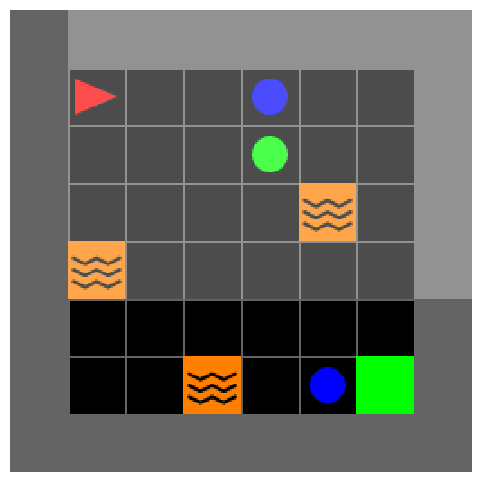

In [133]:
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image
import imageio
import base64
from io import BytesIO
import numpy as np
import time
import copy

#test the environment

def plot_state(env):
    img = env.render()

    plt.imshow(img)
    plt.axis("off")
    plt.show()
    
# env = CustomEnv(size = 8, render_mode='rgb_array', difficult_grid=False, agent_pov=True, step_count_observation=False)
# env = ImgObsWrapper(ObjObsWrapper(env))
grid_size = 8
max_steps = 300
agent_view_size = 7
lava_cost = -5
colors_rewards = {'red':3, 'green': 1, 'blue': 0}
kwargs = {
    "initial_balls": initial_balls,
    "other_lava_cells": other_lava_cells,
    "grid_size": grid_size,
    "render_mode": 'rgb_array',
    "max_steps": max_steps,
    "highlight": True,
    "unique_env": 0,
    "step_count_observation": False,
    "num_objects": 4,
    "train_env": True,
    "image_full_view": False,
    "agent_view_size": agent_view_size,
    "colors_rewards": colors_rewards,
    "simillarity_level": 3,
    "num_lava_cells": 4,
}

env = CustomEnv(**kwargs)
        
env = NoDeath(ObjObsWrapper(env), no_death_types=('lava',), death_cost=lava_cost)
# env = ObjObsWrapper(env)


current_obs = env.reset()
current_obs = current_obs[0]
plot_state(env)



In [136]:
current_obs = env.reset()
current_obs = current_obs[0]
plot_state(env)

reset new env with balls: [(4, 4, 'green', 2), (4, 5, 'red', 2), (4, 2, 'red', 2), (5, 6, 'blue', 2)]
lava cells: [(2, 1), (3, 4), (3, 5), (3, 1)]


C:\Users\matan\AppData\Local\Temp\ipykernel_6316\3311627992.py:18: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


In [99]:
initial_balls = env.get_wrapper_attr('initial_balls')
other_lava_cells = env.get_wrapper_attr('lava_cells')
print(other_lava_cells)
print(initial_balls)

[(4, 5), (2, 4), (4, 3)]
[(5, 6, 'blue', 2), (4, 1, 'red', 2), (4, 2, 'red', 2)]


In [4]:
import os
models_names = [
                # 'models/0,5,0,-3,0.2Steps100Grid8_20241231',
                'models/1,1,1,-3.0,0.01Steps200Grid8_20250416',
                'models/1,1,1,0.0,0.01Steps200Grid8_20250416',
                'models/2,-0.1,2,0,0.01Steps200Grid8_20250416',
                'models/2,0,2,-3,0.01Steps200Grid8_20250416',
                'models/2,0,2,-3,0.01Steps200Grid8_20250416',
                # 'models/2,2,2,-1,0.2Steps200Grid8_20250324',
                # 'models/2,2,2,-3,0.2Steps100Grid8_20241230',
                # 'models/2,2,2,-3,0.2Steps100Grid8_20241231',
                # 'models/2,2,2,0,0.1Steps250Grid8_20241225',
                # 'models/3,0,0,-4,0.2Steps300Grid8_20250106',
                # 'models/3,1,0,-4,0.2Steps300Grid8_20250106',
                # 'models/3,1,0,-4,0.2Steps300Grid8_20250109',
                # 'models/3,3,3,-0.1,0.2Steps300Grid8_20250406',
                'models/3,3,3,-5,0.1Steps100Grid8_20250417',
                # 'models/3,3,3,0,0.1Steps100Grid8_Step_Count_20250327',
                # 'models/4,-0.1,-0.1,-4,0.2Steps300Grid8_20250129',
                # 'models/5,5,5,-4,0.2Steps200Grid8_Step_Count_20250325',
                ]

models_names = [path.split("/")[1] for path in models_names]


# model_name = models_names[0]
# model_path = os.path.join("models", model_name, "best_model")
# env = create_env_from_model_name(model_name)
# agent = load_agent(env, model_path)
# print(evaluate_agent(env, agent))



In [28]:
def create_env(model_name, grid_size, agent_view_size, max_steps, highlight, num_objects, lava_cells, train_env=True, image_full_view=False):
    env_info = model_name.split('S')[0].split(',')
    lava_cost = float(env_info[3])
    step_cost = float(env_info[4])
    colors_rewards = {'red':float(env_info[0]), 'green': float(env_info[1]), 'blue': float(env_info[2])}
    step_count = True if 'Step_Count' in model_name else False
    base_env =  CustomEnv(
            grid_size=grid_size,
            render_mode='rgb_array',
            max_steps=max_steps,
            highlight=highlight,
            step_cost=step_cost,
            num_objects=num_objects,
            lava_cells=lava_cells,
            train_env=train_env,
            image_full_view=image_full_view,
            agent_view_size=agent_view_size,
            color_rewards=colors_rewards,
            step_count_observation=step_count
        )
    base_env = NoDeath(ObjObsWrapper(base_env), no_death_types=('lava',), death_cost=lava_cost)
    env = Monitor(base_env)  # Add Monitor for logging
    
    # env = DummyVecEnv([lambda: env])
    # env = VecNormalize(env, norm_obs=True, norm_reward=False, clip_obs=10.0)

    return env



model_name = '1,1,1,-1,0.01Steps200Grid8_20250409' #'1,1,1,-1,0.01Steps200Grid8_20250409'
grid_size = 8
max_steps = 200
agent_view_size = 7
num_balls = 4
num_lava_cell = 4
env = create_env(
        model_name=model_name,
        grid_size=grid_size,
        agent_view_size=agent_view_size,
        max_steps=max_steps,
        highlight=True,
        num_objects=num_balls,
        lava_cells=num_lava_cell,
        train_env=True,
        image_full_view=False,
        )
# env = VecNormalize(env, norm_obs=True, norm_reward=False, clip_obs=10.0)
# env_instance = CustomEnv(
#         grid_szie=8, render_mode="rgb_array", image_full_view=False,
#         highlight=True, max_steps=100, num_objects=5, lava_cells=3, partial_obs=True,
#         unique_env=0
#     )
# env = NoDeath(ObjObsWrapper(env_instance), no_death_types=("lava",), death_cost=-3)
model_path = os.path.join("models", model_name, "best_model")
# agent = load_agent(env, model_path, update=True)
# eval_res = evaluate_agent(env, agent, 10)
# print(eval_res)

observation size: 7


In [9]:
models_evaluations = []
for model_name in models_names:
    env = create_env_from_model_name(model_name)
    model_path = os.path.join("models", model_name, "best_model")
    agent = load_agent(env, model_path)
    eval_res = evaluate_agent(env, agent)
    models_evaluations.append({"model name": model_name, "model mean score": eval_res[0], "model mean illegal moves": eval_res[1], "model mean steps": eval_res[2]})

observation size: 7
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.
Observation space: Dict('image': Box(0, 255, (3, 7, 7), uint8))
Environment Observation Space: Dict('image': Box(0, 255, (7, 7, 3), uint8))
PPO Model Observation Space: Dict('image': Box(0, 255, (3, 7, 7), uint8))
reached max steps=200
observation size: 7
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.
Observation space: Dict('image': Box(0, 255, (3, 7, 7), uint8))
Environment Observation Space: Dict('image': Box(0, 255, (7, 7, 3), uint8))
PPO Model Observation Space: Dict('image': Box(0, 255, (3, 7, 7), uint8))
observation size: 7
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.
Observation space: Dict('image': Box(0, 255, (3, 7, 7), uint8))
Environment Observation Space: Dict('image': Box(0, 255, (7, 7, 3), uint

In [10]:
for model_eval in models_evaluations:
    print(model_eval)

{'model name': '1,1,1,-3.0,0.01Steps200Grid8_20250416', 'model mean score': 4.829935000000016, 'model mean illegal moves': 2, 'model mean steps': 21}
{'model name': '1,1,1,0.0,0.01Steps200Grid8_20250416', 'model mean score': 3.7995800000000104, 'model mean illegal moves': 0, 'model mean steps': 11}
{'model name': '2,-0.1,2,0,0.01Steps200Grid8_20250416', 'model mean score': 3.5698900000000124, 'model mean illegal moves': 0, 'model mean steps': 11}
{'model name': '2,0,2,-3,0.01Steps200Grid8_20250416', 'model mean score': 2.1565799999999387, 'model mean illegal moves': 6, 'model mean steps': 49}
{'model name': '2,0,2,-3,0.01Steps200Grid8_20250416', 'model mean score': 1.972284999999955, 'model mean illegal moves': 6, 'model mean steps': 52}
{'model name': '3,3,3,-5,0.1Steps100Grid8_20250417', 'model mean score': -22.79042999999735, 'model mean illegal moves': 66, 'model mean steps': 151}


In [25]:
import imageio
import os
import time
from IPython.display import Video, display

def create_video_from_images(imgs_action_list, output_path='episode_video.mp4', fps=1):
    """Save images to a video file."""
    # Write images to a video file
    imageio.mimsave(output_path, imgs_action_list, fps=fps)
    print(f"Video saved to {output_path}")

# Ensure the directory exists
video_path = 'videos/episode_video.mp4'
os.makedirs(os.path.dirname(video_path), exist_ok=True)

random_seed = np.random.randint(0, 10000)

# model_name = models_names[-1]
model_name = "1,1,1,0.0,0.01Steps200Grid8_20250416"
model_path = os.path.join("models", model_name, "best_model")
env = create_env(model_name,
                grid_size=8,
                 agent_view_size=7,
                 max_steps=100,
                 highlight=True,
                 num_objects=4,
                 lava_cells=6,
                 train_env=True,
                 seed=random_seed,)
agent = load_agent(env, model_path, False) # false = use regular ObjExtractor, true = use upgraded ObjExtractor
images_list = []


# for i in range(num_episodes):
#         # kwargs = {'simillarity_level': 3}
#         state = env.unwrapped.reset()
#         state = {'image': state['image']}
#         done = False
#         while not (done):
#             last_obs = state
#             agent_pos_before = env.envs[0].unwrapped.agent_pos
#             # print(state)
#             action, _ = agent.predict(state)
#             state, reward, done, truncle = env.unwrapped.step(action)
#             total_reward += reward
#             total_moves += 1
#             if is_illegal_move(action, last_obs, state, agent_pos_before, env.envs[0].unwrapped.agent_pos):
#                 total_illegal_moves += 1

for i in range(2):  # Two episodes
    done = False
    current_obs = env.unwrapped.reset()
    current_obs = current_obs[0]
 
    current_obs = {'image': current_obs['image']}

    j = 0
    while not done:
        action, _ = agent.predict(current_obs)
        current_obs, reward, done, _, _ = env.unwrapped.step(action)
        current_obs = {'image': current_obs['image']}
        print(f"index - i: {j}, action: {action}, reward: {reward}, done: {done}")
        img = env.unwrapped.render()  # Get the rendered frame
        images_list.append(img)
        time.sleep(0.3)  # Slow down for visualization
        j+=1

# Ensure images_list is not empty
if images_list:
    create_video_from_images(images_list, output_path=video_path, fps=4)

    # Display the video inline in Jupyter
    display(Video(video_path, embed=True))
else:
    print("No images to create video.")


observation size: 7
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.
Observation space: Dict('image': Box(0, 255, (3, 7, 7), uint8))
Environment Observation Space: Dict('image': Box(0, 255, (7, 7, 3), uint8))
PPO Model Observation Space: Dict('image': Box(0, 255, (3, 7, 7), uint8))
index - i: 0, action: 2, reward: -0.09, done: False
index - i: 1, action: 2, reward: -0.08, done: False
index - i: 2, action: 2, reward: -0.07, done: False
index - i: 3, action: 2, reward: -0.06, done: False
index - i: 4, action: 2, reward: -0.05, done: False
index - i: 5, action: 1, reward: -0.05, done: False
index - i: 6, action: 3, reward: 0.95, done: False
index - i: 7, action: 2, reward: -0.04, done: False
index - i: 8, action: 2, reward: -0.03, done: False
index - i: 9, action: 2, reward: -0.02, done: False
index - i: 10, action: 2, reward: -0.01, done: False
index - i: 11, action: 2, reward: 3.892, done: True
index - i: 0, action: 2, reward: -0.09, done: False
index - i: 1, 

In [53]:
print(len(images_list))

26


In [ ]:
# save in CSV preference vector and evaluation

name = 'LavaLaverNR_Grid8_20241113'
model_path = 'models\LavaLaverRedN8_20241113\iter_500000_steps' 
pref_vector = [-2,2,2,0,-0.1] # (red ball, green ball, blue ball, lava, step penalty)
evaluation = evaluate_agent(env, load_agent(env, model_path), num_episodes=100)
add_path_to_csv(name, model_path, pref_vector, evaluation)

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.
Observation space: Dict('image': Box(0, 255, (3, 7, 7), uint8))
reached max steps=100
reached max steps=100
reached max steps=100
reached max steps=100
reached max steps=100


dict_keys(['image', 'direction', 'mission'])
observation size: 7
dict_keys(['image'])


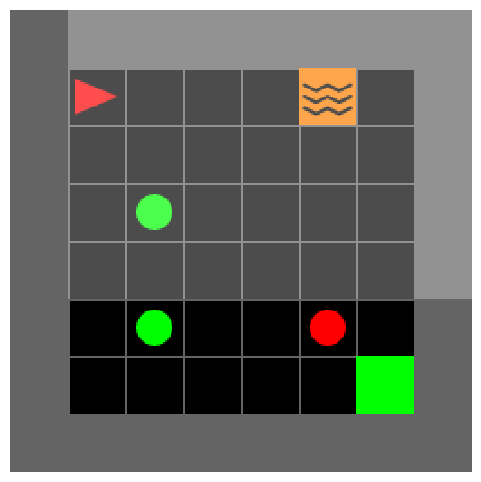

points {0: (1, 1, 0), 1: (2, 5, 2), 2: (2, 3, 2), 3: (2, 5, 2), 4: (5, 5, 2)}
Total reward: 6.0, Total steps: 10.0


c:\Users\matan\anaconda3\envs\master_env\lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.find_optimal_path to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.find_optimal_path` for environment variables or `env.get_wrapper_attr('find_optimal_path')` that will search the reminding wrappers.
  logger.warn(


In [10]:
#test the environment

def plot_state(env):
    img = env.render()

    plt.imshow(img)
    plt.axis("off")
    plt.show()

env = CustomEnv(grid_size=8, render_mode='rgb_array', difficult_grid=False, max_steps=300, highlight=True, unique_env=0,
                        num_objects=5, lava_cells=2, train_env=True, image_full_view=False, agent_view_size=7, partial_obs=False)
state, _ = env.reset()
print(state.keys())
env = NoDeath(ObjObsWrapper(env), no_death_types=('lava',), death_cost=-1.0)
# env = ImgObsWrapper(ObjObsWrapper(env))

state, _ = env.reset()
print(state.keys())
plot_state(env)


#test the environment
total_reward, total_steps = env.find_optimal_path()
print(f"Total reward: {total_reward}, Total steps: {total_steps}")
env.close()

In [9]:

move_sequence, illigal_moves, total_reward, ligal_actions = capture_agent_path(env, agent)
buf, actions_with_location, buf_list = plot_all_move_sequence(img=env.render(), move_sequence=move_sequence, agent_true_actions=ligal_actions)

KeyError: 'direction'

In [30]:
def load_agent(env, model_path):
    # policy_kwargs = dict(features_extractor_class=ObjEnvExtractor)
    custom_objects = {
        "policy_kwargs": {"features_extractor_class": ObjEnvExtractor},  # Example kernel size
        "clip_range": 0.2,  # Example custom parameters
        "lr_schedule": 0.001  # Example learning rate schedule
    }
    # Load the model
    ppo = PPO.load(f"models/{model_path}", custom_objects=custom_objects, env=env)
    return ppo

def is_illegal_move(action, last_obs, obs, agent_pos_befor, agent_pos):
    if action <= 1: # turn is always legal
        return False
    if action == 2 and agent_pos_befor == agent_pos:
        return True
    if action > 2 and np.array_equal(obs['image'], last_obs['image']):
        return True
    return False

# resert the environment and run the agent on that environment to find his path
def capture_agent_path(copy_env, agent):
    illigal_moves = 0
    last_obs = copy_env.unwrapped.current_state
    
    # last_obs = env.reset()
    # last_obs = last_obs[0]
    ligal_actions = []
    agent_actions = []
    state_record = [last_obs]
    total_reward = 0    
    done = False
    # copy_env = copy.deepcopy(env)
    # plt.imshow(copy_env.render())
    while not done:
        agent_pos_before = copy_env.unwrapped.agent_pos
        action, _states = agent.predict(last_obs)
        agent_actions.append(action)
        obs, reward, done, _, info = copy_env.step(action)
        total_reward += reward
        
        if is_illegal_move(action, last_obs, obs, agent_pos_before, copy_env.agent_pos):
            illigal_moves += 1
            continue

        ligal_actions.append(action)
        last_obs = obs
        state_record.append(obs)
        # plt.imshow(copy_env.render())
        # plt.show()
        
        
    number_to_action = {0: 'turn right', 1: 'turn left', 3: 'pickup'}
    small_arrow = 'turn ' # small arrow is used to indicate the agent turning left or right
    agent_dir = "right"
    move_sequence = []
    for action in ligal_actions:
        if action == 0: # turn left
            agent_dir = turn_agent(agent_dir, "left")
            move_sequence.append(small_arrow + agent_dir)
        elif action == 1: # turn right
            agent_dir = turn_agent(agent_dir, "right")
            move_sequence.append(small_arrow + agent_dir)
        elif action == 2: # move forward
            move_sequence.append(agent_dir)
        elif action == 3: # pickup
            move_sequence.append('pickup ' +  agent_dir)
    return move_sequence, illigal_moves, total_reward, agent_actions


def turn_agent(agent_dir, turn_dir):
    turnning_dict = {("up", "left"): "left", ("up", "right"): "right", 
                     ("down", "left"): "right", ("down", "right"): "left",
                     ("left", "left"): "down", ("left", "right"): "up",
                     ("right", "left"): "up", ("right", "right"): "down"}
    return turnning_dict[(agent_dir, turn_dir)]

def plot_move_sequence(img, move_sequence, move_color='y', turn_color='orange', pickup_color='purple'):    
    start_point = (50, 50)
    arrow_size = 20
    arrow_head_size = 12
    small_shift = 9
    all_arrow_size = arrow_size + arrow_head_size
    move_arrow_sizes = {'up': (0, -20, 0, -all_arrow_size), 
                        'down': (0, 20, 0, all_arrow_size), 
                        'right': (20, 0, all_arrow_size, 0), 
                        'left': (-20, 0, -all_arrow_size, 0)}
    turn_arrow_sizes = {'turn up': (0, -5),
                        'turn down': (0, 5),
                        'turn right': (5, 0),
                        'turn left': (-5, 0)}
    pickup_direction = {'up': (0, -1),
                         'down': (0, 1),
                         'left': (-1, 0),
                         'right': (1, 0)}
    # arrows_list = ['right', 'right', 'down', 'down', 'down', 'down', 'down', 'right', 'right', 'up', 'right', 'down']

    fig, ax = plt.subplots()
    ax.imshow(img)
    current_point = start_point
    for action_name in move_sequence:
        if action_name in move_arrow_sizes.keys(): # a big arrow that represents a move
            ax.arrow(current_point[0], current_point[1], move_arrow_sizes[action_name][0], move_arrow_sizes[action_name][1], head_width=10, head_length=10, fc=move_color, ec=move_color)
            current_point = (current_point[0] + move_arrow_sizes[action_name][2], current_point[1] + move_arrow_sizes[action_name][3])
        else: # a small arrow that represents a turn or a pickup
            full_action = action_name.split(' ')
            action = full_action[0]
            pickup_position = pickup_direction[full_action[1]]
            
            if action == 'pickup':
                ax.plot(current_point[0] + small_shift * pickup_position[0], current_point[1] + small_shift*pickup_position[1], marker='*', markersize=10, color=pickup_color)
            else:
                ax.arrow(current_point[0], current_point[1], turn_arrow_sizes[action_name][0], turn_arrow_sizes[action_name][1], head_width=7, head_length=6, fc=turn_color, ec=turn_color)
            
            
    ax.axis('off')
    plt.show()

colors_reward = {'red': -2, 'green': 1, 'blue': 2}
env = CustomEnv(grid_size=8, render_mode='rgb_array', max_steps=2*10**2, agent_view_size=7, highlight=True, lava_cells=0, 
                partial_obs=False, colors_rewards=colors_reward)
env = NoDeath(ObjObsWrapper(env), no_death_types=('lava',), death_cost=-2.0)
model_path1 = "LavaHate8_20241112\iter_500000_steps"
model_path2 = "LavaLaver8_20241112\iter_500000_steps"

ppo1 = load_agent(env, "minigrid_custom_20240907/iter_90^5_steps")
ppo3 = load_agent(env, "orig_easy8_20241111\iter_1000000_steps")
ppo7 = load_agent(env, "LavaLaverRedN8_20241113\iter_500000_steps")
ppo5 = load_agent(env, model_path2)
ppo9 = load_agent(env, model_path1)
models = {"ppo1": ppo1, "ppo3": ppo3, "ppo5": ppo5,  "ppo7": ppo7,  "ppo9": ppo9}
colors_list = [
    "cyan", "magenta", "yellow", "white",
    "orange", "purple", "pink", "brown", "gray", "olive", "teal", "navy",
    "maroon", "lime", "indigo", "gold"]
colors_to_models = {"ppo1": "y", "ppo3": "w", "ppo5": "gold", "ppo7": "c", "ppo9": "gray"}


7
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.


In [ ]:
def evaluate_agent(env, agent, num_episodes=100):
    total_reward = 0
    total_illegal_moves = 0
    for i in range(num_episodes):
        env.reset()
        move_sequence, illigal_moves, reward, agent_actions = capture_agent_path(env, agent)
        total_reward += reward
        total_illegal_moves += illigal_moves
    return total_reward / num_episodes, total_illegal_moves / num_episodes

for model_name, model in models.items():
    avg_reward, avg_illegal_moves, avg_moves = evaluate_agent(env, model, num_episodes=100)
    print(f"Model: {model_name}, Average reward: {avg_reward}, Average illegal moves: {avg_illegal_moves}")

c:\Users\matan\anaconda3\envs\master_env\lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.grid to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.grid` for environment variables or `env.get_wrapper_attr('grid')` that will search the reminding wrappers.
  logger.warn(
c:\Users\matan\anaconda3\envs\master_env\lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.front_pos to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.front_pos` for environment variables or `env.get_wrapper_attr('front_pos')` that will search the reminding wrappers.
  logger.warn(
c:\Users\matan\anaconda3\envs\master_env\lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.actions to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.actions` for environment va

Model: ppo1, Average reward: 4.0252, Average illegal moves: 4.75
Model: ppo3, Average reward: 6.048430000000001, Average illegal moves: 0.2
Model: ppo5, Average reward: 5.1891400000000045, Average illegal moves: 0.74
Model: ppo7, Average reward: 8.971045000000004, Average illegal moves: 0.18
Model: ppo9, Average reward: 4.6684149999999995, Average illegal moves: 0.05


reset state:


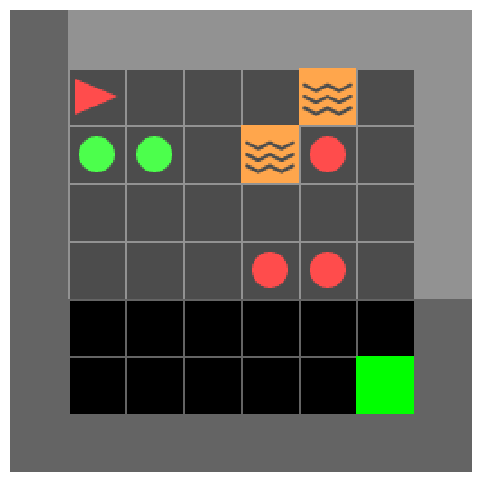

NameError: name 'models' is not defined

In [11]:
env.reset()
img = env.render()
print("reset state:")
plot_state(env)
model_name = 'ppo1'
model = models[model_name]
# for model_name, model in models.items():
#     copy_env = copy.deepcopy(env)
#     # print("copy_env before:")
#     # plot_state(copy_env)
#     move_sequence, illigal_moves, total_reward, agent_action = capture_agent_path(copy_env, model)
#     # print("all actions: ", agent_action)
#     print("ligal actions: ", move_sequence)
#     print(f"model: {model_name}, illigal moves: {illigal_moves}, total reward: {total_reward}")

#     plot_move_sequence(img, move_sequence, move_color=colors_to_models[model_name])
#     # print("orig env after:")
#     # plot_state(env)
    


## Distance between 2 states

In [6]:
WALL_SHIFT_FACTOR = 1
WALL_FACTOR = 10
DOOR_FACTOR = 0.1
BALLS_FACTOR = 3
min_ball_distance = 3

def manhattan_distance(p1, p2):
    return np.abs(p1[0] - p2[0]) + np.abs(p1[1] - p2[1])
    
def balls_distance(balls):
    ball_dist = 0
    for i in range(len(balls)-1):
        for j in range(i+1, len(balls)):
            ball_dist += np.linalg.norm(np.array(balls[i][:-1]) - np.array(balls[j][:-1]))
    return ball_dist

def balls_groups(balls_list):
    print(f"balls_list: {balls_list}")
    groups = []
    in_any_group = set()
    for i in range(len(balls_list)):
        if i in in_any_group:
            continue
        group = [balls_list[i]]
        need_to_check = [i]
        in_any_group.add(i)
        while need_to_check:
            ball_index = need_to_check.pop()
            check_ball = balls_list[ball_index]
            for j in range(len(balls_list)):
                if j in in_any_group: # TODO: option to switch to a list with all the balls that are not in any group
                    continue
                if manhattan_distance(check_ball, balls_list[j]) <= min_ball_distance:
                    group.append(balls_list[j])
                    in_any_group.add(j)
                    need_to_check.append(j)
        groups.append(group)
    print(f"groups: {groups}")
    
    res = []
    for group in groups:
        x_center = np.mean([ball[0] for ball in group])
        y_center = np.mean([ball[1] for ball in group])
        res.append((len(group), (x_center, y_center)))
    print(f"res: {res}")
    return res

def biggest_group(balls_groups):
    max = 0
    max_group = None
    for group in balls_groups:
        if group[0] > max:
            max = group[0]
            max_group = group
    return max_group
    
def state_distance(objects1, objects2):
    distance = 0
    if objects1['wall'][0] or objects2['wall'][0]: # if one of the states has a wall
        if objects1['wall'][0] != objects2['wall'][0]:
            distance += WALL_FACTOR
        else:
            distance += np.abs((objects1['wall'][2]) - (objects2['wall'][2]))*DOOR_FACTOR
            distance += np.abs((objects1['wall'][1]) - (objects2['wall'][1]))*WALL_SHIFT_FACTOR
    
    ball_groups1 = balls_groups(objects1['balls'])
    ball_groups2 = balls_groups(objects2['balls'])
    max_group1 = biggest_group(ball_groups1)
    max_group2 = biggest_group(ball_groups2)
    distance += np.abs(max_group1[0] - max_group2[0])*BALLS_FACTOR # changes in the biggest group size
    distance += np.abs(len([group for group in ball_groups1 if group[0] > 1]) - len([group for group in ball_groups2 if group[0] > 1]))# change in number of real groups(more then 1 ball)
    # distance += np.abs(balls_distance(objects1['balls']) - balls_distance(objects2['balls']))* BALLS_FACTOR
    return distance

In [7]:
import numpy as np
# !pip install ipdb
import ipdb

def calculate_distance(state1, state2):
    """
    Calculate the Euclidean distance between two states represented by images.
    
    Parameters:
    state1 (np.ndarray): The first state image.
    state2 (np.ndarray): The second state image.
    
    Returns:
    float: The Euclidean distance between the two states.
    """
    # Flatten the images
    flat_state1 = state1.flatten()
    flat_state2 = state2.flatten()
    
    # Calculate the Euclidean distance
    distance = np.linalg.norm(flat_state1 - flat_state2)
    
    return distance

# Example usage
grid_size=10
env = CustomEnv(grid_size=grid_size, render_mode='rgb_array', difficult_grid=False, max_steps=100, highlight=True,
                num_objects=7, lava_cells=2, train_env=True, image_full_view=False, agent_view_size=grid_size*2-1)
env = NoDeath(ObjObsWrapper(env), no_death_types=('lava',), death_cost=-2.0)
state1, _ = env.reset()
state1 = state1['image']
plot_state(env)
objects1 = env.grid_objects()
state2, _ = env.reset()
objects2 = env.grid_objects()
# plot_state(env)
print(f"objects1: {objects1}")
# print(f"objects2: {objects2}")
distance = state_distance(objects1, objects2)
print(f"Distance between the two states: {distance}")

ModuleNotFoundError: No module named 'ipdb'

In [ ]:
def plot_state(env):
    img = env.render()
    plt.imshow(img)
    plt.axis("off")
    plt.show()

### Manual Control

In [ ]:
from minigrid_custom_env import CustomEnv
# from base_env import SimpleEnv 
from minigrid.manual_control import ManualControl

env = CustomEnv(render_mode="human", difficult_grid=True, agent_pov=True)

# enable manual control for testing
manual_control = ManualControl(env, seed=42)
manual_control.start()

    


error: video system not initialized

## RL Control


### Train With PPO

In [ ]:
import minigrid
from minigrid.wrappers import ImgObsWrapper
from stable_baselines3 import PPO
from custom_env import *

from custom_env import SimpleEnv 
import os

models_dir = "models/PPO"
log_dir = "logs"
if not os.path.exists(models_dir):
    os.makedirs(models_dir)
if not os.path.exists(log_dir):
    os.makedirs(log_dir)

env = SimpleEnv(render_mode="rgb_array", max_steps=10)
env = FullyObsWrapper(env)

policy_kwargs = dict(
    features_extractor_class=MinigridFeaturesExtractor,
    features_extractor_kwargs=dict(features_dim=128),
)

env = SimpleEnv(render_mode="rgb_array", max_steps=10)
env = ImgObsWrapper(env)

model = PPO("CnnPolicy", env, policy_kwargs=policy_kwargs, verbose=1, tensorboard_log=log_dir)

TIMSTEMPS = 10000
for i in range(1, 15):
    model.learn(total_timesteps=TIMSTEMPS, reset_num_timesteps=False, tb_log_name="PPO")
    model.save(f"{models_dir}/model_{i}")
# model.learn(2e5)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.
Logging to logs\PPO_0
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 10       |
|    ep_rew_mean     | 32.5     |
| time/              |          |
|    fps             | 399      |
|    iterations      | 1        |
|    time_elapsed    | 5        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10          |
|    ep_rew_mean          | 39.5        |
| time/                   |             |
|    fps                  | 266         |
|    iterations           | 2           |
|    time_elapsed         | 15          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.016745023 |
|    clip_fraction        | 0.259       |

#### load a model

In [ ]:
model_path = f"{models_dir}/model_13.zip"
load_model = PPO.load(model_path, env=env)

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.


### Random Agent

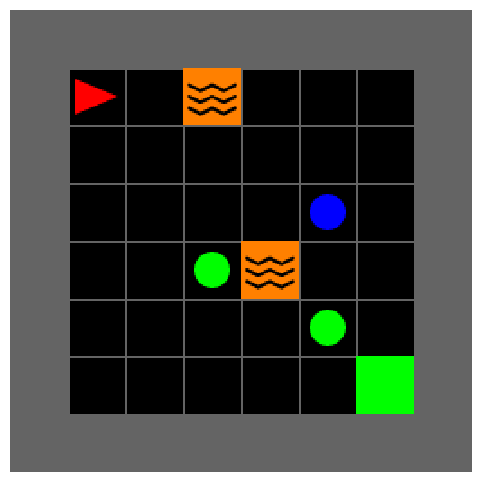

Action: 3,  Reward: -0.1, Done: False, Truncated: False, Info: {}


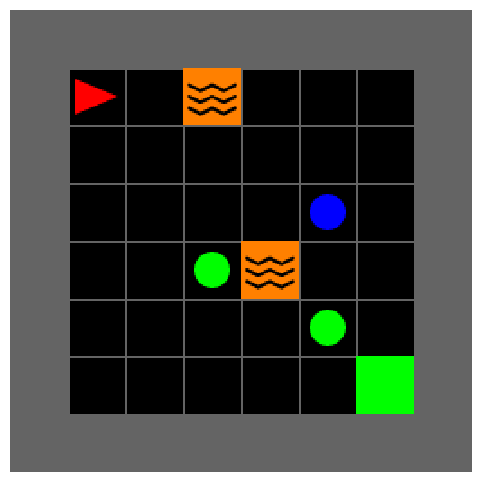

In [ ]:
def plot_state(env):
    img = env.render()
    plt.imshow(img)
    plt.axis("off")
    plt.show()

env = CustomEnv(render_mode="rgb_array", max_steps=10)
num_episodes = 2
for i in range(num_episodes):
# Reset the environment to get the initial state
    state, info = env.reset()
    # plot_state(env)
    score = 0
    # Run the simulation
    done = False
    plot_state(env)
    while not done:
        # Sample a random action from the action space
        action = env.action_space.sample()

        # Take the action in the environment
        state, reward, done, truncated, info = env.step(action)
        score += reward
        if reward != 0:
            print(f"Action: {action},  Reward: {reward}, Done: {done}, Truncated: {truncated}, Info: {info}")
            plot_state(env)

    plot_state(env)
    print(f"episode {i}: score: {score}")

env.close()


In [ ]:
from app_db import *
from datetime import datetime

with app.app_context():
    db.create_all()
    players = Player.query.all()

    print(players)

[Player(1, 1)]
